In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error


Missing values in each column: Series([], dtype: int64)
Number of duplicate rows: 0


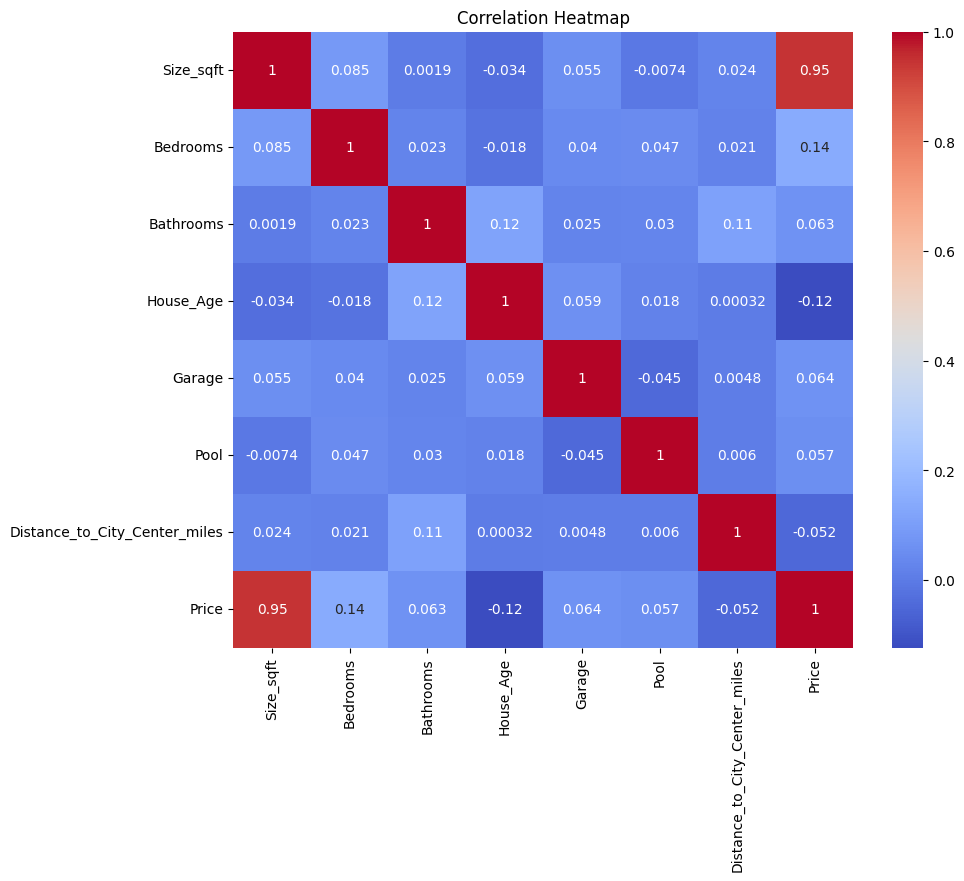

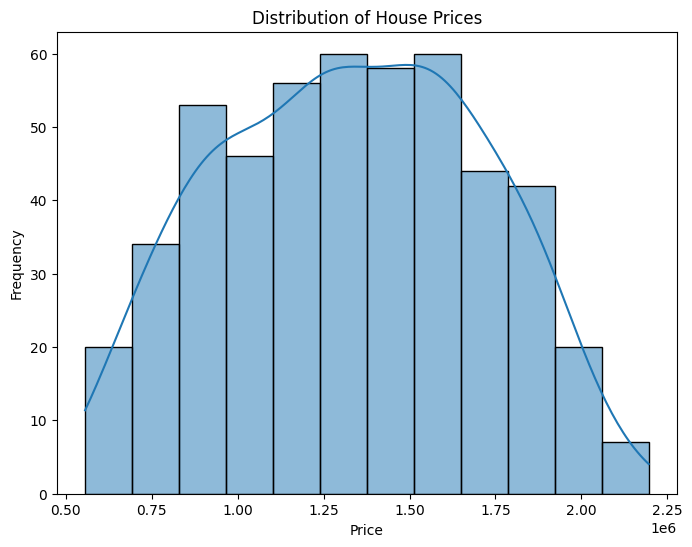

In [16]:
#Load Data
df=pd.read_csv("house_prices_dataset.csv")

##---------------Data Preprocessing------------------##

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values in each column: {missing_values[missing_values > 0]}")
# Drop rows with missing values
df = df.dropna()

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
# Drop duplicate rows
df = df.drop_duplicates()


num_features = ['Size_sqft', 'Bedrooms', 'Bathrooms', 'House_Age', 'Garage', 'Pool', 'Distance_to_City_Center_miles']

plt.figure(figsize=(10, 8))
sns.heatmap(df[num_features + ['Price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Distribution of the target variable (price)
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


# Handle numerical features (impute + scale)
numerical_features = ['Size_sqft', 'Bedrooms', 'Bathrooms', 'House_Age', 'Garage', 'Pool', 'Distance_to_City_Center_miles']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Handle categorical features (impute + encode)
categorical_features = ['Location']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# LINEAR REGRESSION

In [27]:
from sklearn.model_selection import train_test_split

# Prepare data
X = df.drop('Price', axis=1)
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the training data using the preprocessor defined earlier
X_train = preprocessor.fit_transform(X_train)

# Preprocess the testing data using the preprocessor defined earlier
X_test = preprocessor.transform(X_test)

# Initialize a Linear Regression model
model = LinearRegression()

# Fit the Linear Regression model to the preprocessed training data
model.fit(X_train, y_train)

# Perform cross-validation to evaluate the Linear Regression model
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_lr = -cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='neg_root_mean_squared_error')
cv_mae_lr = -cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='neg_mean_absolute_error')
cv_r2_lr = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='r2')

# Print the cross-validation metrics for Linear Regression
print("Linear Regression Cross-Validation Metrics:")
print("Average RMSE: {:.2f}".format(cv_rmse_lr.mean()))
print("Average MAE: {:.2f}".format(cv_mae_lr.mean()))
print("Average R²: {:.2f}".format(cv_r2_lr.mean()))


Linear Regression Cross-Validation Metrics:
Average RMSE: 11550.73
Average MAE: 9847.40
Average R²: 1.00


# DECISION TREE

In [30]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Decision Tree Regressor
best_depth = None
best_r2 = -np.inf

# Iterate through different max_depth values for the Decision Tree Regressor
for depth in range(1, 11):
    cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Perform cross-validation to evaluate the Decision Tree Regressor
    cv_rmse_dt = -cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='neg_root_mean_squared_error')
    cv_mae_dt = -cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='neg_mean_absolute_error')
    cv_r2_dt = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='r2')
    
    # Check if current depth has a better average R² score
    if cv_r2_dt.mean() > best_r2:
        best_r2 = cv_r2_dt.mean()
        best_depth = depth
        
print(f"Optimal depth: {best_depth}")

# Fit the Decision Tree Regressor model to the preprocessed training data
model = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
model.fit(X_train, y_train)

# Evaluate the Decision Tree Regressor model on the test set
y_pred_dt = model.predict(X_test)
rmse_dt = root_mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Print the test set metrics for Decision Tree Regressor
print("Decision Tree Test Metrics:")
print("RMSE: {:.2f}".format(rmse_dt))
print("MAE: {:.2f}".format(mae_dt))
print("R²: {:.2f}".format(r2_dt))
# Convert predicted and test values to binary based on a threshold
threshold = y_test.median()  # You can adjust this threshold as needed
y_pred_binary_dt = (y_pred_dt > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

# Calculate metrics
accuracy_dt = accuracy_score(y_test_binary, y_pred_binary_dt)
precision_dt = precision_score(y_test_binary, y_pred_binary_dt)
recall_dt = recall_score(y_test_binary, y_pred_binary_dt)
f1_dt = f1_score(y_test_binary, y_pred_binary_dt)

# Print the metrics
print("Decision Tree Metrics (Binary):")
print("Accuracy: {:.2f}".format(accuracy_dt))
print("Precision: {:.2f}".format(precision_dt))
print("Recall: {:.2f}".format(recall_dt))
print("F1 Score: {:.2f}".format(f1_dt))

Optimal depth: 10
Decision Tree Test Metrics:
RMSE: 79394.79
MAE: 62126.09
R²: 0.95
Decision Tree Metrics (Binary):
Accuracy: 0.99
Precision: 0.98
Recall: 1.00
F1 Score: 0.99
